# Relative Slope (RELS)

https://www.linnsoft.com/techind/relative-slope-rels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-09-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-04,57.102501,57.294998,56.657501,57.090000,54.461620,109560400
2018-09-05,57.247501,57.417500,56.275002,56.717499,54.106270,133332000
2018-09-06,56.557499,56.837502,55.325001,55.775002,53.207169,137160000
2018-09-07,55.462502,56.342499,55.177502,55.325001,52.777882,150479200
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.069561,158066000


In [3]:
# Calculate the typical price (HLC/3)
df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

# Calculate the EMA of the typical price (default period P=20)
P = 20
df['EMA_Typical_Price'] = df['Typical_Price'].ewm(span=P, adjust=False).mean()

# Calculate the working variable Y
df['X'] = df['EMA_Typical_Price']
df['Y'] = 2 * (df['X'] - df['X'].shift(1)) / (df['X'] + df['X'].shift(1))

# Smooth the Y values with a 3-period EMA
df['RELS'] = 100 * df['Y'].ewm(span=3, adjust=False).mean()


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Typical_Price,EMA_Typical_Price,X,Y,RELS
Date,,,,,,,,,,,
2018-09-04,57.102501,57.294998,56.657501,57.090000,54.461620,109560400,57.014167,57.014167,57.014167,NaN,NaN
2018-09-05,57.247501,57.417500,56.275002,56.717499,54.106270,133332000,56.803333,56.994087,56.994087,-0.000352,-0.035224
2018-09-06,56.557499,56.837502,55.325001,55.775002,53.207169,137160000,55.979168,56.897428,56.897428,-0.001697,-0.102482
2018-09-07,55.462502,56.342499,55.177502,55.325001,52.777882,150479200,55.615000,56.775292,56.775292,-0.002149,-0.158686
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.069561,158066000,54.720834,56.579630,56.579630,-0.003452,-0.251954


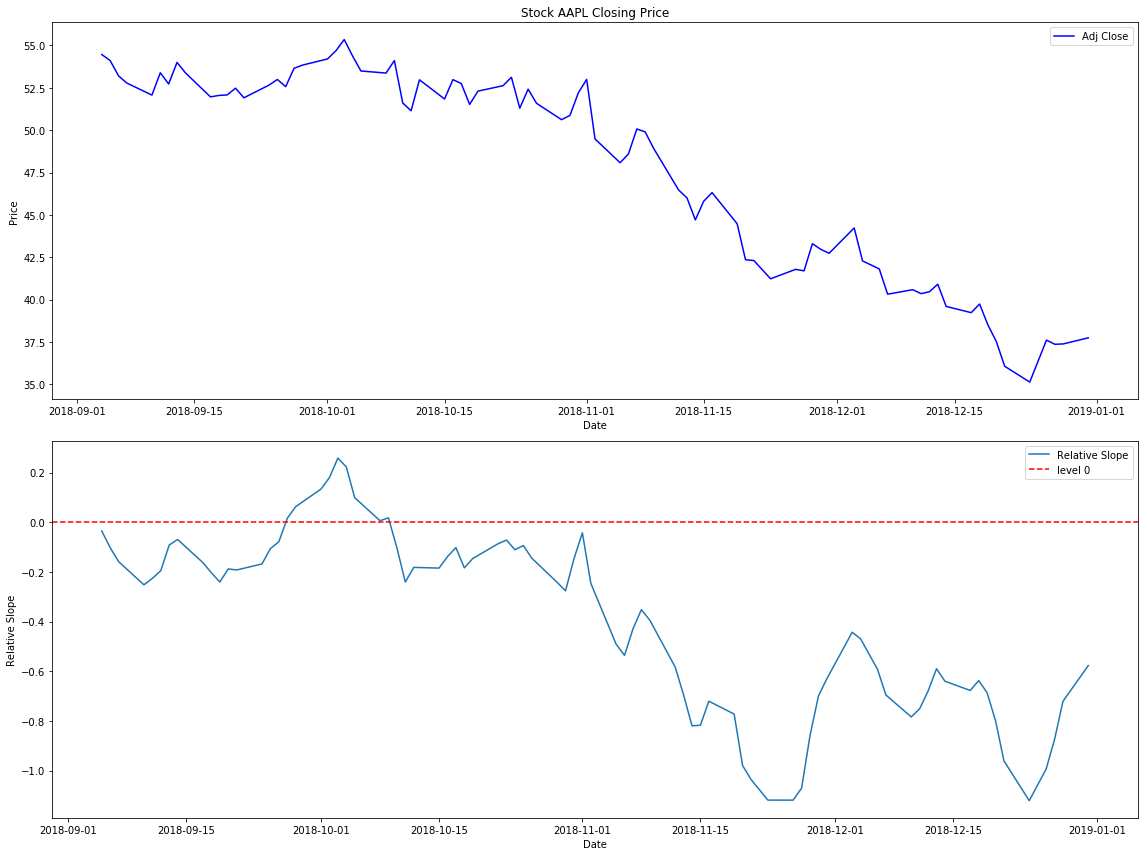

In [5]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'], label='Adj Close', color='blue')
ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.legend(loc='best')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['RELS'], label='Relative Slope')
ax2.axhline(y=0, color='r', linestyle='--', label='level 0')
ax2.set_ylabel('Relative Slope')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

## Candlestick with Relative Slope (RELS)

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Typical_Price,EMA_Typical_Price,X,Y,RELS,VolumePositive
0,736941.0,57.102501,57.294998,56.657501,57.090000,54.461620,109560400,57.014167,57.014167,57.014167,NaN,NaN,False
1,736942.0,57.247501,57.417500,56.275002,56.717499,54.106270,133332000,56.803333,56.994087,56.994087,-0.000352,-0.035224,False
2,736943.0,56.557499,56.837502,55.325001,55.775002,53.207169,137160000,55.979168,56.897428,56.897428,-0.001697,-0.102482,False
3,736944.0,55.462502,56.342499,55.177502,55.325001,52.777882,150479200,55.615000,56.775292,56.775292,-0.002149,-0.158686,False
4,736947.0,55.237499,55.462502,54.117500,54.582500,52.069561,158066000,54.720834,56.579630,56.579630,-0.003452,-0.251954,False


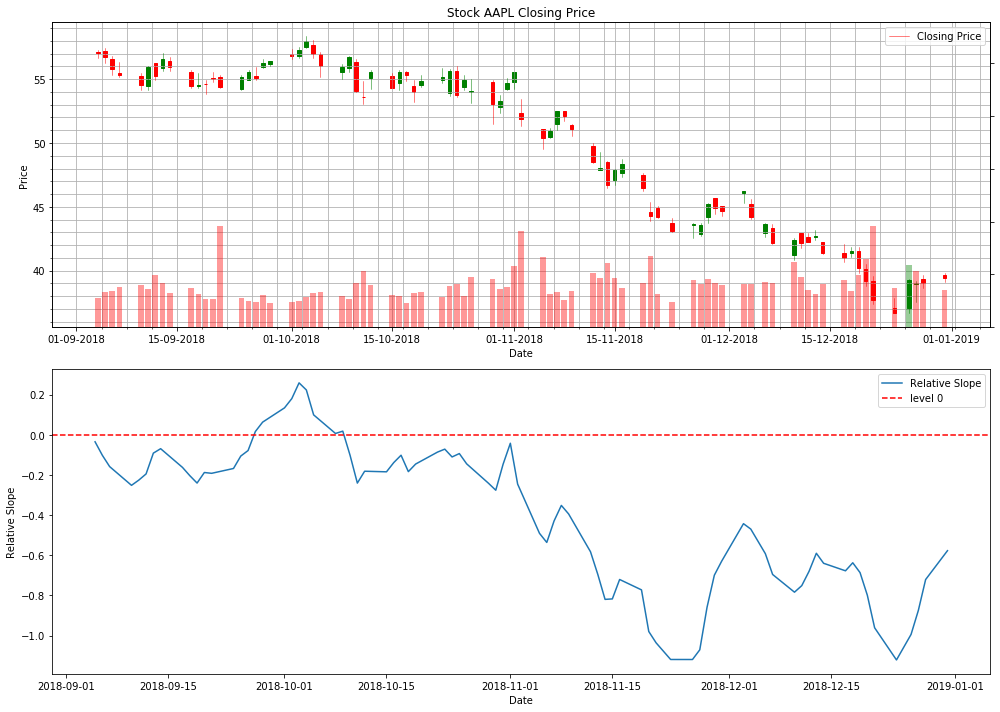

In [7]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1, dfc[['Date', 'Open', 'High', 'Low', 'Close']].values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3 * dfc.Volume.max())
ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
ax1.legend(['Closing Price'], loc='best')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['RELS'], label='Relative Slope')
ax2.axhline(y=0, color='r', linestyle='--', label='level 0')
ax2.set_ylabel('Relative Slope')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

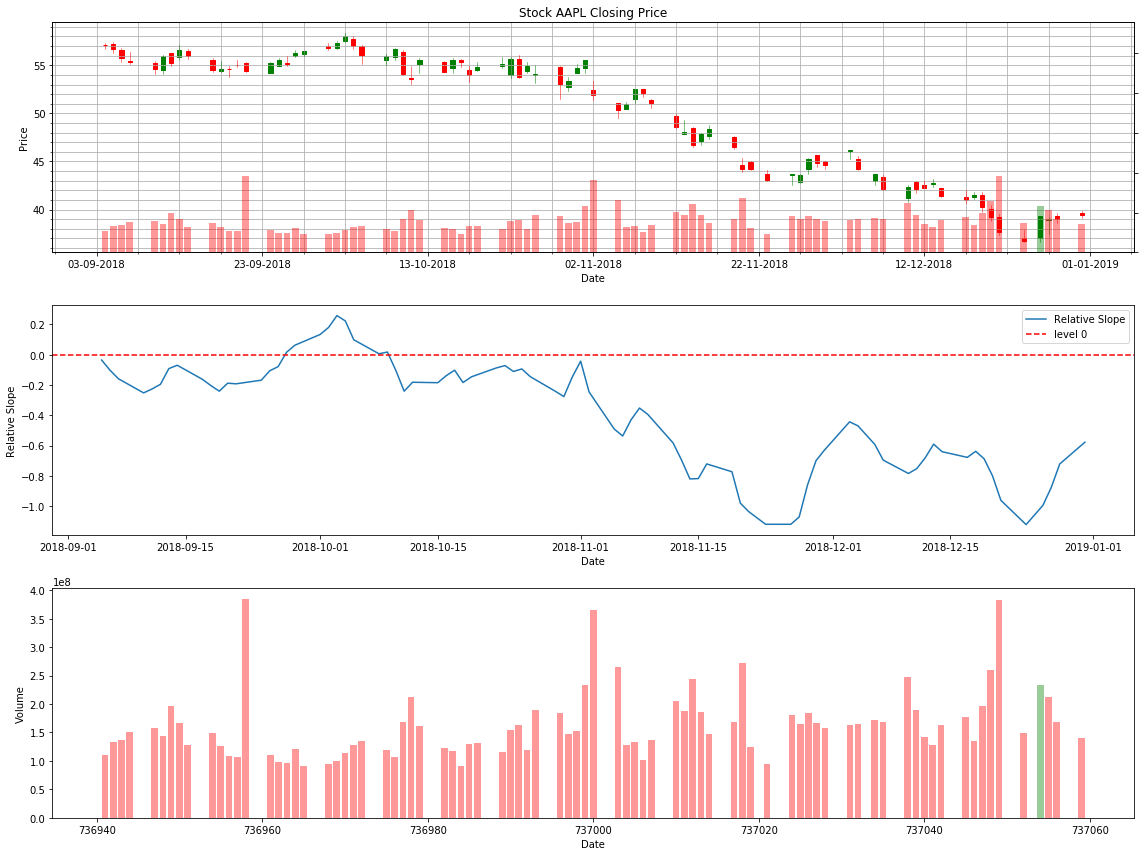

In [8]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(3, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df['RELS'], label='Relative Slope')
ax2.axhline(y=0, color='r', linestyle='--', label='level 0')
ax2.set_ylabel('Relative Slope')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

ax3 = plt.subplot(3, 1, 3)
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax3.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax3.set_ylabel('Volume')
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()